In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K

#### Data Analysis

In [5]:
# read img and mask
mask_paths = glob('brain-mri-seg/train/*_mask.tif')
mask_path = np.random.choice(mask_paths, size=1)[0]
img_path = mask_path.replace('_mask', '')

print('img_path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

img_path:  brain-mri-seg/train/TCGA_FG_A60K_20040224_55.tif
mask path: brain-mri-seg/train/TCGA_FG_A60K_20040224_55_mask.tif


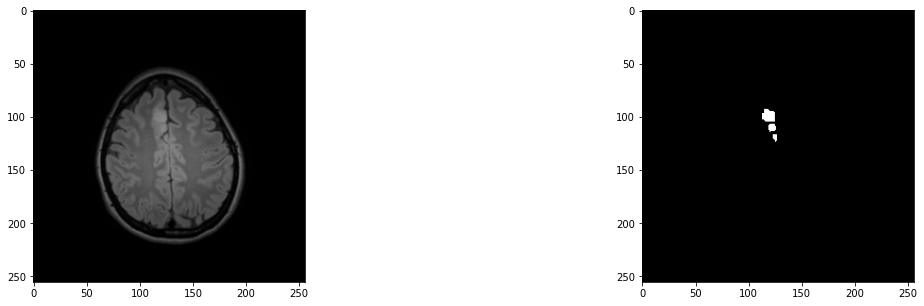

In [6]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

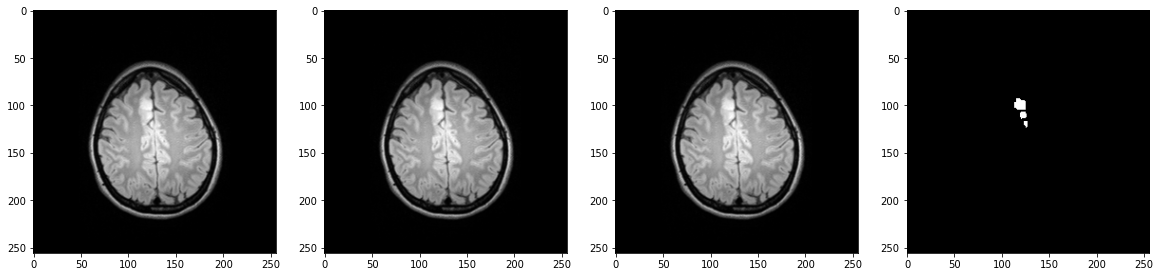

In [7]:
# show channelwise image 
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(img[:,:,i], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(mask)
plt.show()

In [8]:
img.shape, mask.shape

((256, 256, 3), (256, 256, 3))

#### Data processing

In [9]:
IMG_SIZE = 256
BS = 64

In [10]:
class DataGenerator(utils.Sequence):
    def __init__(self, folder_path, batch_size, img_size, shuffle=True, aug=False):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])

        self.mask_paths = glob(os.path.join(folder_path, '*_mask.tif'))
        self.img_paths = [p.replace('_mask', '') for p in self.mask_paths]
        self.indexes = np.arange(len(self.mask_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)
            # img and mask preprocess
            img = self.preprocess(img)
            mask = self.preprocess(mask)
            x[i] = img
            y[i] = mask[:,:,:1]
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y
    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [11]:
train_gen = DataGenerator('brain-mri-seg/train', BS, IMG_SIZE, aug=True)
test_gen = DataGenerator('brain-mri-seg/test', BS, IMG_SIZE, aug=False)

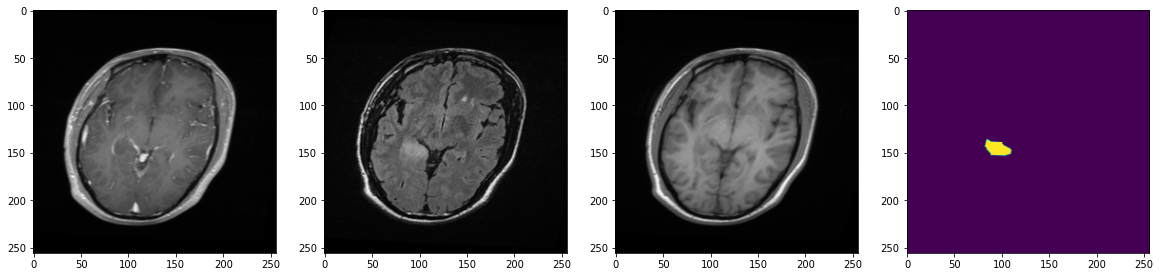

In [12]:
# Check output

batch_x, batch_y = train_gen[0]

for batch_i in range(1):
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1,4,i+1)
        plt.imshow(batch_x[batch_i, :,:,i], cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(batch_y[batch_i, :,:, 0])
    plt.show()

#### Build model

In [13]:
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
c1 = layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(c1)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
c2 = layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(c2)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
c3 = layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(c3)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
c4 = layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(c4)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
c5 = layers.ReLU()(x)
x = layers.MaxPool2D(strides=(2,2))(c5)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
c6 = layers.ReLU()(x)

x = layers.concatenate([layers.UpSampling2D(size=(2,2))(c6), c5], axis=-1)
x = layers.Conv2D(filters=128, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x), c4], axis=-1)
x = layers.Conv2D(filters=128, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=128, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x), c3], axis=-1)
x = layers.Conv2D(filters=64, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x), c2], axis=-1)
x = layers.Conv2D(filters=32, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x), c1], axis=-1)
x = layers.Conv2D(filters=32, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=(2,2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=(1,1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=(1,1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                         
model = models.Model(input_layer, output_layer)

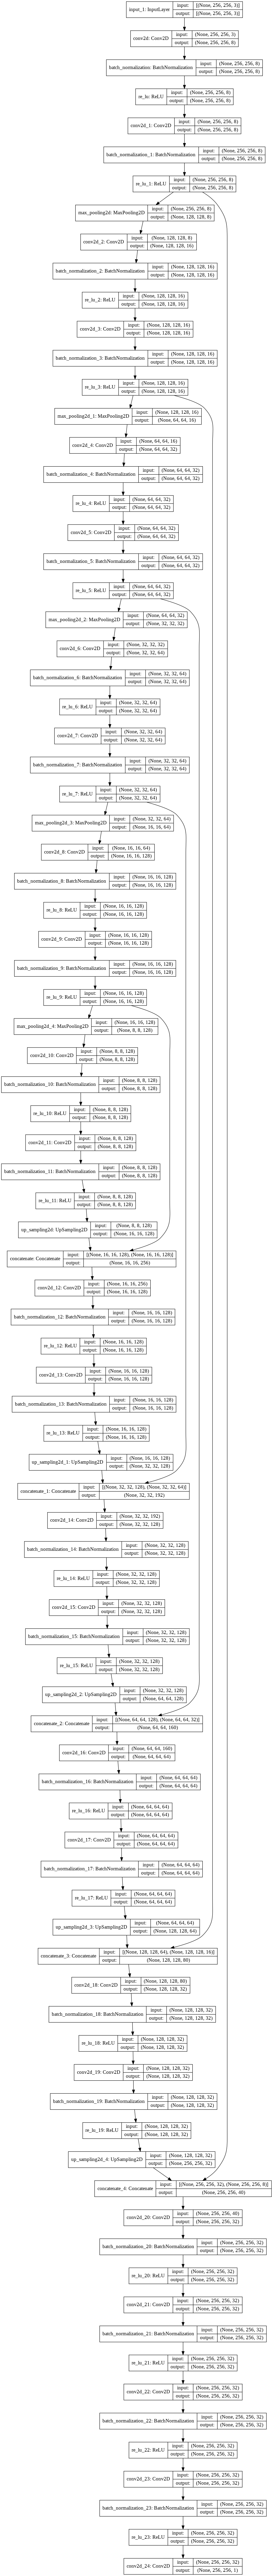

In [14]:
utils.plot_model(model, show_shapes=True)

#### Training

In [15]:
# Customize Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [16]:
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', 
              metrics=[dice_coef])

In [17]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=30)
lr = callbacks.ReduceLROnPlateau("val_loss", factor=0.2, patience=3, min_lr=0.001)

In [18]:
logs = model.fit(train_gen,
                 validation_data = test_gen,
                 epochs=1000,
                 callbacks = [weight_saver, earlystop, lr])

Epoch 1/1000
18/18 [==============================] - 57s 950ms/step - loss: 0.3457 - dice_coef: 0.0905 - val_loss: 0.6402 - val_dice_coef: 0.0591
Epoch 2/1000
18/18 [==============================] - 17s 938ms/step - loss: 0.1753 - dice_coef: 0.1915 - val_loss: 0.5634 - val_dice_coef: 0.0591
Epoch 3/1000
18/18 [==============================] - 17s 946ms/step - loss: 0.1221 - dice_coef: 0.2692 - val_loss: 0.4819 - val_dice_coef: 0.0585
Epoch 4/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0983 - dice_coef: 0.3145 - val_loss: 0.4307 - val_dice_coef: 0.0560
Epoch 5/1000
 5/18 [=======>......................] - ETA: 10s - loss: 0.0799 - dice_coef: 0.3688

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 5823975653376.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 6236292513792.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 7473243095040.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 922ms/step - loss: 0.0809 - dice_coef: 0.3713 - val_loss: 0.3690 - val_dice_coef: 0.0615
Epoch 6/1000
18/18 [==============================] - 17s 923ms/step - loss: 0.0775 - dice_coef: 0.4217 - val_loss: 0.3281 - val_dice_coef: 0.0554
Epoch 7/1000
16/18 [=========================>....] - ETA: 1s - loss: 0.0576 - dice_coef: 0.4715

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (-110907460898303918145411401592141250560.00000000, 1.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 931ms/step - loss: 0.0739 - dice_coef: 0.4515 - val_loss: 0.2713 - val_dice_coef: 0.0612
Epoch 8/1000
18/18 [==============================] - 17s 933ms/step - loss: 0.0591 - dice_coef: 0.4620 - val_loss: 0.2110 - val_dice_coef: 0.1087
Epoch 9/1000
18/18 [==============================] - 17s 931ms/step - loss: 0.0537 - dice_coef: 0.4929 - val_loss: 0.1874 - val_dice_coef: 0.0554
Epoch 10/1000
18/18 [==============================] - 17s 926ms/step - loss: 0.0513 - dice_coef: 0.5219 - val_loss: 0.1611 - val_dice_coef: 0.0977
Epoch 11/1000
18/18 [==============================] - 17s 929ms/step - loss: 0.0589 - dice_coef: 0.5367 - val_loss: 0.1379 - val_dice_coef: 0.1331
Epoch 12/1000
18/18 [==============================] - 17s 931ms/step - loss: 0.0401 - dice_coef: 0.5819 - val_loss: 0.1172 - val_dice_coef: 0.1775
Epoch 13/1000
18/18 [==============================] - 17s 929ms/step - loss: 0.0433 - dice_coef: 0.5799 - val_loss: 0.1231 - va

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 136683039227904.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 141424683122688.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 154618822656000.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 927ms/step - loss: 0.0342 - dice_coef: 0.6324 - val_loss: 0.0964 - val_dice_coef: 0.2771
Epoch 16/1000
18/18 [==============================] - 17s 927ms/step - loss: 0.0312 - dice_coef: 0.6585 - val_loss: 0.0653 - val_dice_coef: 0.4436
Epoch 17/1000
18/18 [==============================] - 17s 927ms/step - loss: 0.0310 - dice_coef: 0.6592 - val_loss: 0.0562 - val_dice_coef: 0.5020
Epoch 18/1000
18/18 [==============================] - 17s 929ms/step - loss: 0.0372 - dice_coef: 0.6459 - val_loss: 0.0537 - val_dice_coef: 0.4953
Epoch 19/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0487 - dice_coef: 0.6484 - val_loss: 0.0559 - val_dice_coef: 0.5002
Epoch 20/1000
18/18 [==============================] - 17s 927ms/step - loss: 0.0338 - dice_coef: 0.6541 - val_loss: 0.0386 - val_dice_coef: 0.6109
Epoch 21/1000
18/18 [==============================] - 17s 927ms/step - loss: 0.0306 - dice_coef: 0.6790 - val_loss: 0.0378 - 

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 25924422598656.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 26474178412544.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (-105590548915164254653796173351019872256.00000000, 1.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 927ms/step - loss: 0.0314 - dice_coef: 0.6926 - val_loss: 0.0253 - val_dice_coef: 0.7394
Epoch 27/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0327 - dice_coef: 0.7056 - val_loss: 0.0286 - val_dice_coef: 0.6862
Epoch 28/1000
18/18 [==============================] - 17s 929ms/step - loss: 0.0451 - dice_coef: 0.7012 - val_loss: 0.0231 - val_dice_coef: 0.7358
Epoch 29/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0286 - dice_coef: 0.7185 - val_loss: 0.0236 - val_dice_coef: 0.7344
Epoch 30/1000
18/18 [==============================] - 17s 925ms/step - loss: 0.0286 - dice_coef: 0.7198 - val_loss: 0.0247 - val_dice_coef: 0.7211
Epoch 31/1000
18/18 [==============================] - 17s 925ms/step - loss: 0.0279 - dice_coef: 0.7118 - val_loss: 0.0223 - val_dice_coef: 0.7694
Epoch 32/1000
18/18 [==============================] - 17s 929ms/step - loss: 0.0445 - dice_coef: 0.7187 - val_loss: 0.0242 - 

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 145822729633792.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 150220776144896.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 928ms/step - loss: 0.0411 - dice_coef: 0.7188 - val_loss: 0.0234 - val_dice_coef: 0.7820
Epoch 35/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0288 - dice_coef: 0.7282 - val_loss: 0.0232 - val_dice_coef: 0.7643
Epoch 36/1000
18/18 [==============================] - 17s 930ms/step - loss: 0.0252 - dice_coef: 0.7522 - val_loss: 0.0258 - val_dice_coef: 0.7519
Epoch 37/1000
18/18 [==============================] - 17s 930ms/step - loss: 0.0187 - dice_coef: 0.7774 - val_loss: 0.0201 - val_dice_coef: 0.7936
Epoch 38/1000
18/18 [==============================] - 17s 926ms/step - loss: 0.0273 - dice_coef: 0.7571 - val_loss: 0.0222 - val_dice_coef: 0.7585
Epoch 39/1000
18/18 [==============================] - 17s 926ms/step - loss: 0.0274 - dice_coef: 0.7399 - val_loss: 0.0246 - val_dice_coef: 0.7593
Epoch 40/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0284 - dice_coef: 0.7499 - val_loss: 0.0223 - 

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (-988767468178018933167428500193280.00000000, 1.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 927ms/step - loss: 0.0400 - dice_coef: 0.8219 - val_loss: 0.0158 - val_dice_coef: 0.8493
Epoch 114/1000
18/18 [==============================] - 17s 922ms/step - loss: 0.0438 - dice_coef: 0.8034 - val_loss: 0.0158 - val_dice_coef: 0.8310
Epoch 115/1000
18/18 [==============================] - 17s 931ms/step - loss: 0.0226 - dice_coef: 0.8158 - val_loss: 0.0149 - val_dice_coef: 0.8565
Epoch 116/1000
18/18 [==============================] - 17s 931ms/step - loss: 0.0462 - dice_coef: 0.7868 - val_loss: 0.0155 - val_dice_coef: 0.8404
Epoch 117/1000
 3/18 [====>.........................] - ETA: 12s - loss: 0.0135 - dice_coef: 0.8439

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 485159505756160.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 927ms/step - loss: 0.0391 - dice_coef: 0.7930 - val_loss: 0.0152 - val_dice_coef: 0.8496
Epoch 118/1000
18/18 [==============================] - 17s 924ms/step - loss: 0.0430 - dice_coef: 0.8005 - val_loss: 0.0208 - val_dice_coef: 0.8174
Epoch 119/1000
18/18 [==============================] - 17s 925ms/step - loss: 0.0198 - dice_coef: 0.8180 - val_loss: 0.0157 - val_dice_coef: 0.8405
Epoch 120/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0180 - dice_coef: 0.8223 - val_loss: 0.0154 - val_dice_coef: 0.8348
Epoch 121/1000
18/18 [==============================] - 17s 930ms/step - loss: 0.0214 - dice_coef: 0.8131 - val_loss: 0.0148 - val_dice_coef: 0.8365
Epoch 122/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0227 - dice_coef: 0.8208 - val_loss: 0.0168 - val_dice_coef: 0.8276
Epoch 123/1000
18/18 [==============================] - 17s 929ms/step - loss: 0.0180 - dice_coef: 0.8251 - val_loss: 0.0

/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 372244480.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))
/usr/local/lib/python3.7/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (-184596537914630191849516205496432852992.00000000, 1.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


18/18 [==============================] - 17s 926ms/step - loss: 0.0223 - dice_coef: 0.8351 - val_loss: 0.0166 - val_dice_coef: 0.8299
Epoch 177/1000
18/18 [==============================] - 17s 924ms/step - loss: 0.0217 - dice_coef: 0.8282 - val_loss: 0.0147 - val_dice_coef: 0.8420
Epoch 178/1000
18/18 [==============================] - 17s 926ms/step - loss: 0.0205 - dice_coef: 0.8263 - val_loss: 0.0144 - val_dice_coef: 0.8519
Epoch 179/1000
18/18 [==============================] - 17s 927ms/step - loss: 0.0145 - dice_coef: 0.8552 - val_loss: 0.0139 - val_dice_coef: 0.8656
Epoch 180/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0200 - dice_coef: 0.8381 - val_loss: 0.0133 - val_dice_coef: 0.8701
Epoch 181/1000
18/18 [==============================] - 17s 928ms/step - loss: 0.0198 - dice_coef: 0.8338 - val_loss: 0.0143 - val_dice_coef: 0.8524
Epoch 182/1000
18/18 [==============================] - 17s 925ms/step - loss: 0.0181 - dice_coef: 0.8418 - val_loss: 0.0

#### Evaluate

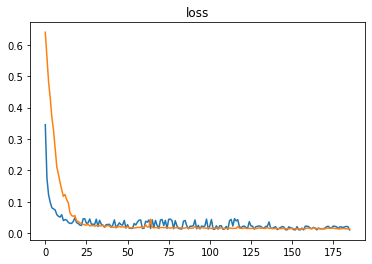

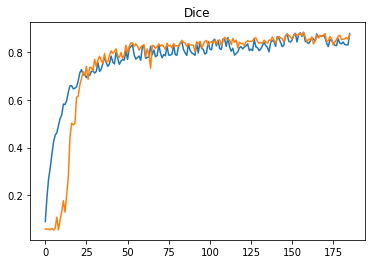

In [24]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [25]:
model_final = models.load_model('seg.h5', compile=False)

3


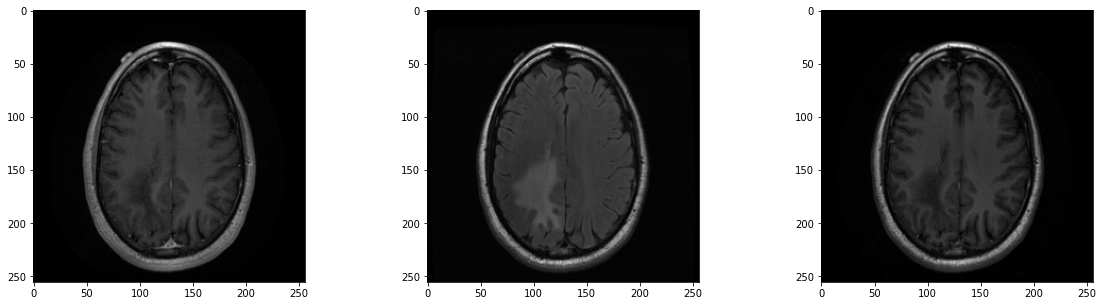

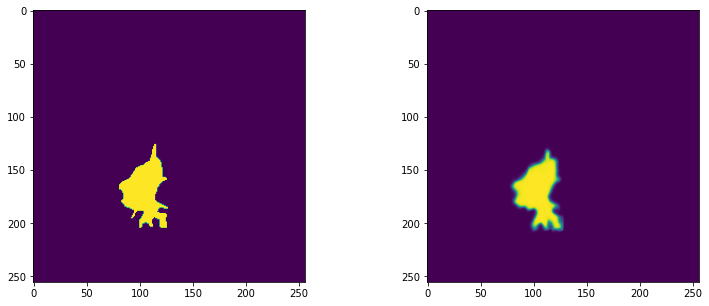

In [26]:
# Sample 1 batch
batch_idx = np.random.randint(len(test_gen))
print(batch_idx)
data = test_gen[batch_idx]
imgs, mask = data # (bs, 256, 256, 3), (bs, 256, 256, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(imgs[img_idx, :,:, i], cmap='gray')
plt.show()

# show ground truth & model prediction
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [27]:
# Displayed by different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[0.00051265, 0.00048633, 0.00047734, ..., 0.00045535, 0.00040656,
        0.00041796],
       [0.00042776, 0.0004201 , 0.00042349, ..., 0.00046044, 0.00041575,
        0.00042019],
       [0.00044978, 0.00044591, 0.00045366, ..., 0.00046337, 0.00041888,
        0.00041802],
       ...,
       [0.00046769, 0.00040566, 0.00039832, ..., 0.00072958, 0.00052217,
        0.00047962],
       [0.00038517, 0.00038378, 0.00037125, ..., 0.00062429, 0.00069935,
        0.00071501],
       [0.00037024, 0.00040262, 0.00041166, ..., 0.00039629, 0.00041561,
        0.00047322]], dtype=float32)

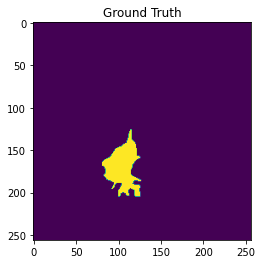

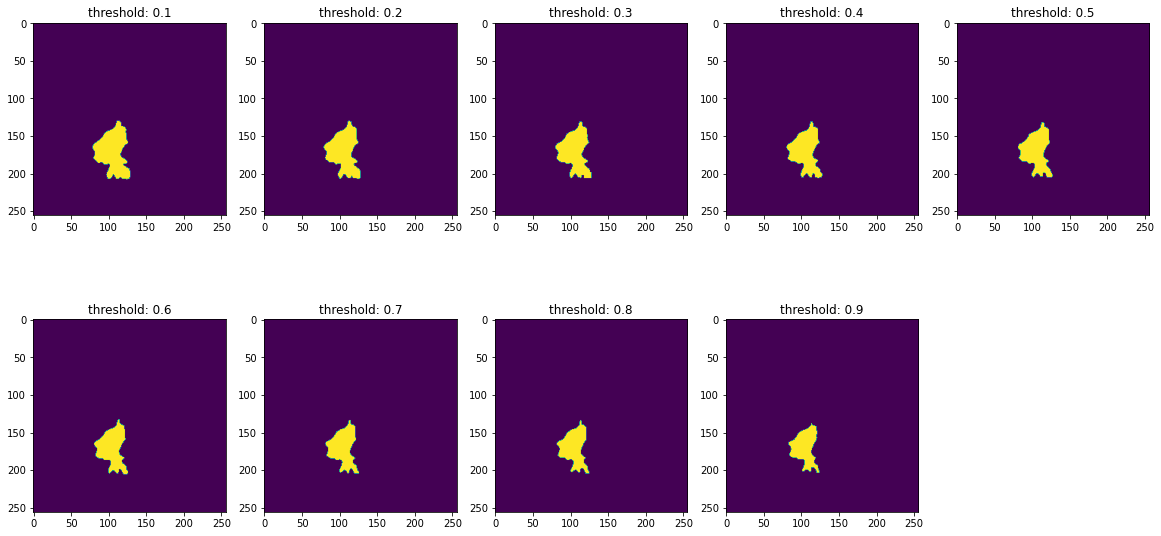

In [28]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()